<a href="https://colab.research.google.com/github/cbev/bross/blob/master/Produce_ANN_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook for generating SSC Time Series from ANN models
Written by Claire Beveridge of University of Washington SASWE Research Group
Originally written on April 21, 2020
Last update April 21, 2020

**To execute the code a cell, select it by clicking on it. Then, either press the play button to the upper left of the code cell, or use the keyboard shortcut "Shift+Enter"**

1. Execute the first two cells below. In the second cell, a box will appear below the cell for you to upload a file.

2. Upload the "ee-chart" file of the surface reflectance time series that was directly downloade from the BROSS GEE application. The file must have the name "ee-chart" for the code to run properly. It will say "Upload complete" when the file is laoded properly.

3. Execute the remaining cells. Time series will be displayed for the 


In [1]:
!git clone 'https://github.com/cbev/BROSS_ann_notebook'

Cloning into 'BROSS_ann_notebook'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [0]:
# Import relevant packages
%tensorflow_version 2.x
import os
os.chdir('/content/BROSS_ann_notebook')
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 1)
import io
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

# Script to upload files
from google.colab import files
if os.path.exists('ee-chart.csv'): os.remove('ee-chart.csv')
df = files.upload()
print('Upload Complete')

Saving ee-chart.csv to ee-chart.csv
Upload Complete


In [0]:
# Import the satellite reflectance data
df = pd.read_csv('ee-chart.csv', index_col=0) # assuming that saved in workspace as 'ee-chart'.
df.SatID=df.SatID.astype(int)
df.index=pd.to_datetime(df.index)    
df=df.groupby(df.index).mean()
df['TotalVIS']=df.Red+df.Blue+df.Green
df['Red_NIR']=df.Red/df.NIR;
df['Red_Green']=df.Red/df.Green;
df['Red_Blue']=df.Red/df.Blue;
df['Month']=df.index.month
df['RG_2']=(df['Red'].astype(np.float64)+df['Green'].astype(np.float64))/2 # (r+g)/2 
df['R_G_N']=(df['Red'].astype(np.float64)/df['Green'].astype(np.float64))+df['NIR'].astype(np.float64)
df=df.sort_index()
df=df[['SatID', 'Blue', 'Green', 'NIR', 'Red', 'TotalVIS', 'Red_Blue', 'Red_Green', 'Red_NIR','RG_2','R_G_N', 'Month']]

scale_matrix = pickle.load(open('/content/BROSS_ann_notebook/scale_matrix.pkl','rb'))

In [0]:
## Where I left off: Need to set it up so that it scales the input data, but also leave it unscaled for regression

ann_L5L7.h5  ann_L8S2.h5  ann_M.h5  ee-chart.csv  scale_matrix.pkl


In [0]:
# Compare ANN and regression- Landsat 8, Sentinel-2
# Import ANN data
ann_model_L8S2 = tf.keras.models.load_model('/content/BROSS_ann_notebook/ann_L8S2.h5')
# ANN X inputs: [0:'LID', 1:'blue', 2:'green', 3:'nir', 4:'red', 5:'total', 6:'rb', 7:'rg', 8:'rn', 9:'sp1', 10:'sp2', 11:'month']

# Regression model
def reg_model_L8S2 (red_over_green, max_ssc):
  ssc=0.161*np.exp(8.871*(red_over_green)-1.15)
  ssc[np.where(ssc>max_ssc)]=max_ssc
  return ssc

# fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
# ax1.plot(L8S2_df.index, L8S2_y,'k.-', linewidth=4, label='Observed')
# ax1.plot(L8S2_df.index, reg_model_L8S2 (L8S2_X_prescaled[:,7], 1500), 'g.-', linewidth=2, label='Regression, r2=0.66, RMSE=135 mg/L')
# ax1.plot(L8S2_df.index, ann_model_L8S2.predict(L8S2_X),'b.-', linewidth=2, label='ANN, r2=0.74, RMSE=139 mg/L')
# ax1.legend(loc='best')
# ax1.set_title('Landsat 8, Sentinel 2\nTime series of ANN and regression models with calibration/testing data')
# ax1.set_ylabel('Model output (SSC, mg/L)')
# ax1.set_xlabel('Index')

# fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
# ax2.plot([0,1500], [0, 1500],'k-')
# ax2.plot(L8S2_y, reg_model_L8S2 (L8S2_X_prescaled[:,7], 1500), 'go', linewidth=2, label='Regression, r2=0.66, RMSE=135 mg/L')
# ax2.plot(L8S2_y, ann_model_L8S2.predict(L8S2_X),'bo', linewidth=2, label='ANN, r2=0.74, RMSE=139 mg/L')
# ax2.legend(loc='best')
# ax2.set_title('Landsat 8, Sentinel 2\nModeled vs. Observed')
# ax2.set_xlabel('Observation (SSC, mg/L)')
# ax2.set_ylabel('Model Output (SSC, mg/L)')
# ax2.loglog()


In [0]:
# Import the calibration dataset data and convert to values






# Define which monitoring points:  Bahadurabad=1, Hardinge Bridge=2, Baruria=3, Mawa=4);
df=df[df['station'].isin([3,4])]
df=df.drop(labels=['station'],axis=1) # drop the 'station' label since want a generalized model that is not dependent on the location

# Define which satellite(s) to get data from- uncomment option: 2=Sentinel-2; 3=MODIS; 5, 7, 8= Landsat 5, 7, 8
L8S2_df=df[df['LID'].isin([2, 8])] # Landsat 8 and Sentinel-2
L8S2_df.reset_index(inplace=True, drop=True)
L8S2_X=L8S2_df.drop(labels=['obs_mgL'],axis=1).values
L8S2_X_prescaled=L8S2_X
L8S2_X=scale(L8S2_X)
L8S2_y=L8S2_df.obs_mgL.values

L5L7_df=df[df['LID'].isin([5, 7])] # Landsat 5 and Landsat 7
L5L7_df.reset_index(inplace=True, drop=True)
L5L7_X=L5L7_df.drop(labels=['LID','obs_mgL'],axis=1).values
L5L7_X_prescaled=L5L7_X
L5L7_X=scale(L5L7_X)
L5L7_y=L5L7_df.obs_mgL.values

M_df=df[df['LID'].isin([3])]    # MODIS
M_df.reset_index(inplace=True, drop=True)
M_X=M_df.drop(labels=['LID','obs_mgL','total'],axis=1).values
M_X_prescaled=M_X
M_X=scale(M_X)
M_y=M_df.obs_mgL.values

print('L8S2 Variables:',L8S2_df.columns)
print('L5L7 Variables:',L5L7_df.columns)
print('M Variables:',M_df.columns)

FileNotFoundError: ignored

[]

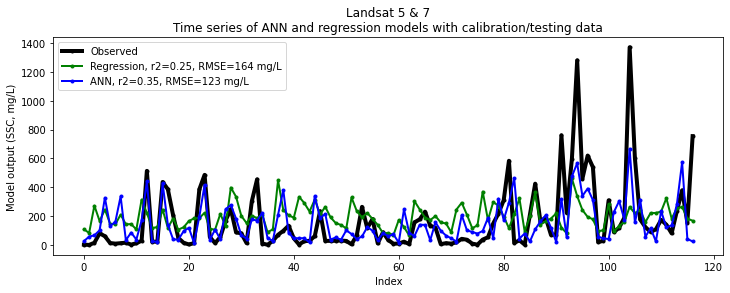

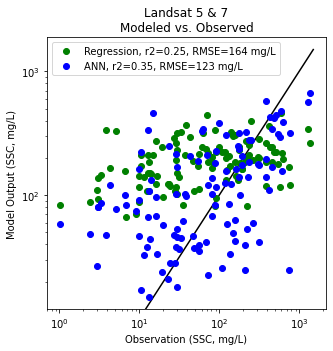

In [0]:
# Compare ANN and regression- Landsat 5 and 7
# Import ANN data
ann_model_run='L5L7_v4' # only thing you should need to update
ann_model_path='/content/drive/My Drive/Colab Notebooks/ann_files/'+ann_model_run+'/'
ann_model_L5L7 = tf.keras.models.load_model(ann_model_path+ann_model_run+'.h5')
# ANN X inputs: [0:'blue', 1:'green', 2:'nir', 3:'red', 4:'total', 5:'rb', 6:'rg', 7:'rn', 8:'sp1', 9:'sp2', 10:'month']

# Regression model
L5L7_reg_input=L5L7_X_prescaled[:,3]
def reg_model_L5L7 (red, max_ssc):
  ssc=3.56*np.exp(14.59*(red)+2.15)
  ssc[np.where(ssc>max_ssc)]=max_ssc
  return ssc

fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
ax1.plot(L5L7_df.index, L5L7_y,'k.-', linewidth=4, label='Observed')
ax1.plot(L5L7_df.index, reg_model_L5L7 (L5L7_reg_input, 1500), 'g.-', linewidth=2, label='Regression, r2=0.25, RMSE=164 mg/L')
ax1.plot(L5L7_df.index, ann_model_L5L7.predict(L5L7_X),'b.-', linewidth=2, label='ANN, r2=0.35, RMSE=123 mg/L')
ax1.legend(loc='best')
ax1.set_title('Landsat 5 & 7\nTime series of ANN and regression models with calibration/testing data')
ax1.set_ylabel('Model output (SSC, mg/L)')
ax1.set_xlabel('Index')

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
ax2.plot([0,1500], [0, 1500],'k-')
ax2.plot(L5L7_y, reg_model_L5L7 (L5L7_reg_input, 1500), 'go', linewidth=2, label='Regression, r2=0.25, RMSE=164 mg/L')
ax2.plot(L5L7_y, ann_model_L5L7.predict(L5L7_X),'bo', linewidth=2, label='ANN, r2=0.35, RMSE=123 mg/L')
ax2.legend(loc='best')
ax2.set_title('Landsat 5 & 7\nModeled vs. Observed')
ax2.set_xlabel('Observation (SSC, mg/L)')
ax2.set_ylabel('Model Output (SSC, mg/L)')
ax2.loglog()


(0.0, 1500.0)

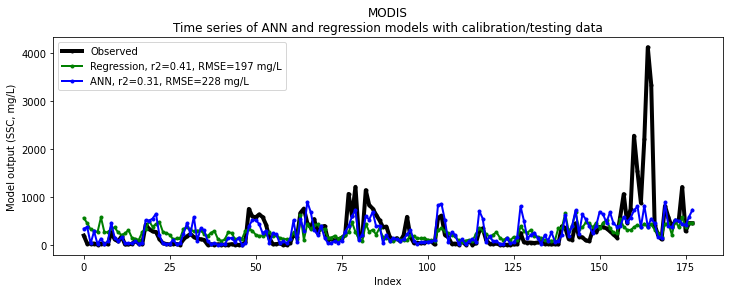

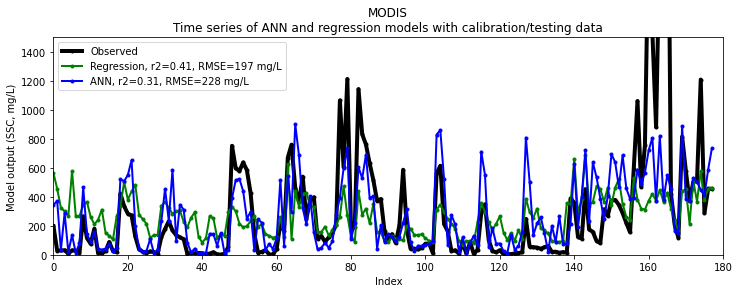

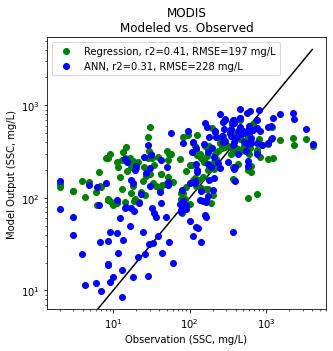

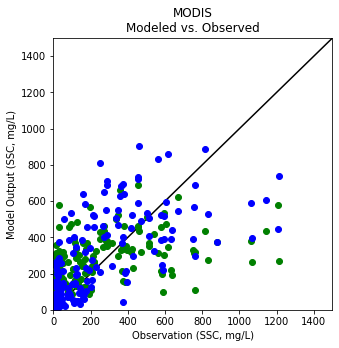

In [0]:
# Compare ANN and regression- MODIS
# Import ANN data
ann_model_run='M_v5' # only thing you should need to update
ann_model_path='/content/drive/My Drive/Colab Notebooks/ann_files/'+ann_model_run+'/'
ann_model_M = tf.keras.models.load_model(ann_model_path+ann_model_run+'.h5')
# ANN X inputs: [0:'blue', 1:'green', 2:'nir', 3:'red', 4:'rb', 5:'rg', 6:'rn', 7:'sp1', 8:'sp2', 9:'month']

# Regression model
def reg_model_M (red, max_ssc):
  ssc=2.74*np.exp(19.8*red+2.36)
  ssc[np.where(ssc>max_ssc)]=max_ssc
  return ssc

fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
ax1.plot(M_df.index, M_y,'k.-', linewidth=4, label='Observed')
ax1.plot(M_df.index, reg_model_M (M_X_prescaled[:,3], 1500), 'g.-', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
ax1.plot(M_df.index, ann_model_M.predict(M_X),'b.-', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
ax1.legend(loc='best')
ax1.set_title('MODIS\nTime series of ANN and regression models with calibration/testing data')
ax1.set_ylabel('Model output (SSC, mg/L)')
ax1.set_xlabel('Index')

fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
ax1.plot(M_df.index, M_y,'k.-', linewidth=4, label='Observed')
ax1.plot(M_df.index, reg_model_M (M_X_prescaled[:,3], 1500), 'g.-', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
ax1.plot(M_df.index, ann_model_M.predict(M_X),'b.-', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
ax1.legend(loc='best')
ax1.set_title('MODIS\nTime series of ANN and regression models with calibration/testing data')
ax1.set_ylabel('Model output (SSC, mg/L)')
ax1.set_xlabel('Index')
ax1.legend(loc='upper left')
axes = plt.gca()
axes.set_xlim([0,180])
axes.set_ylim([0,1500])

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
ax2.plot([0,4000], [0, 4000],'k-')
ax2.plot(M_y, reg_model_M (M_X_prescaled[:,3], 1500), 'go', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
ax2.plot(M_y, ann_model_M.predict(M_X),'bo', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
ax2.legend(loc='best')
ax2.set_title('MODIS\nModeled vs. Observed')
ax2.set_xlabel('Observation (SSC, mg/L)')
ax2.set_ylabel('Model Output (SSC, mg/L)')
ax2.loglog()

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
ax2.plot([0,4000], [0, 4000],'k-')
ax2.plot(M_y, reg_model_M (M_X_prescaled[:,3], 1500), 'go', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
ax2.plot(M_y, ann_model_M.predict(M_X),'bo', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
ax2.set_title('MODIS\nModeled vs. Observed')
ax2.set_xlabel('Observation (SSC, mg/L)')
ax2.set_ylabel('Model Output (SSC, mg/L)')
axes = plt.gca()
axes.set_xlim([0,1500])
axes.set_ylim([0,1500])


In [0]:
M_X_7=M_X[:,[3,1,4,10]]

# Compare ANN and regression- Landsat 5 and 7
# Import ANN data
ann_model_run='M_v7' # only thing you should need to update
ann_model_path='/content/drive/My Drive/Colab Notebooks/ann_files/'+ann_model_run+'/'
ann_model_M7 = tf.keras.models.load_model(ann_model_path+ann_model_run+'.h5')
# ANN X inputs: [0:'red', 1:'green', 2:'total', 3:'month']

# Regression model
def reg_model_M (red, max_ssc):
  ssc=2.74*np.exp(19.8*red+2.36)
  ssc[np.where(ssc>max_ssc)]=max_ssc
  return ssc

fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
ax1.plot(M_df.index, M_y,'k.-', linewidth=4, label='Observed')
ax1.plot(M_df.index, reg_model_M (M_X_prescaled[:,3], 1500), 'g.-', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
ax1.plot(M_df.index, ann_model_M7.predict(M_X_7),'b.-', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
ax1.legend(loc='best')
ax1.set_title('MODIS\nTime series of ANN and regression models with calibration/testing data')
ax1.set_ylabel('Model output (SSC, mg/L)')
ax1.set_xlabel('Index')

fig1, ax1 =plt.subplots(1,1,figsize=(12,4))
ax1.plot(M_df.index, M_y,'k.-', linewidth=4, label='Observed')
ax1.plot(M_df.index, reg_model_M (M_X_prescaled[:,3], 1500), 'g.-', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
ax1.plot(M_df.index, ann_model_M7.predict(M_X_7),'b.-', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
ax1.legend(loc='best')
ax1.set_title('MODIS\nTime series of ANN and regression models with calibration/testing data')
ax1.set_ylabel('Model output (SSC, mg/L)')
ax1.set_xlabel('Index')
ax1.legend(loc='upper left')
axes = plt.gca()
axes.set_xlim([0,180])
axes.set_ylim([0,1500])

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
ax2.plot([0,4000], [0, 4000],'k-')
ax2.plot(M_y, reg_model_M (M_X_prescaled[:,3], 1500), 'go', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
ax2.plot(M_y, ann_model_M.predict(M_X),'bo', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
ax2.legend(loc='best')
ax2.set_title('MODIS\nModeled vs. Observed')
ax2.set_xlabel('Observation (SSC, mg/L)')
ax2.set_ylabel('Model Output (SSC, mg/L)')

fig2, ax2 =plt.subplots(1,1,figsize=(5,5))
ax2.plot([0,4000], [0, 4000],'k-')
ax2.plot(M_y, reg_model_M (M_X_prescaled[:,3], 1500), 'go', linewidth=2, label='Regression, r2=0.41, RMSE=197 mg/L')
ax2.plot(M_y, ann_model_M7.predict(M_X_7),'bo', linewidth=2, label='ANN, r2=0.31, RMSE=228 mg/L')
ax2.set_title('MODIS\nModeled vs. Observed')
ax2.set_xlabel('Observation (SSC, mg/L)')
ax2.set_ylabel('Model Output (SSC, mg/L)')
axes = plt.gca()
axes.set_xlim([0,1500])
axes.set_ylim([0,1500])

IndexError: ignored

In [0]:
os.chdir('/content/drive/My Drive/BROSS')
## Get the mean, std for each set so can transform the GEE outputs ## 
scale_matrix={'L8S2_mean':L8S2_X_prescaled.mean(axis=0),'L8S2_std':L8S2_X_prescaled.std(axis=0),
              'L5L7_mean':L5L7_X_prescaled.mean(axis=0),'L5L7_std':L5L7_X_prescaled.std(axis=0),
              'M_mean':M_X_prescaled.mean(axis=0),'M_std':M_X_prescaled.std(axis=0)}
import pickle
f=open('scale_matrix.pkl','wb')
pickle.dump(scale_matrix,f)
f.close()